In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from exp.nb_XLibrary import *
from fastai import datasets as FAdataset

# Path and data

In [3]:
home_path = Path('.').resolve()
data_path = home_path/'data'
file_path = FAdataset.untar_data(FAdataset.URLs.IMAGENETTE_160, dest=data_path)

In [4]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs=128

il = ImageList.from_files(file_path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=1)
data.train_ds

LabeledData
x: ImageList (12894 items)
[PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_58454.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_32588.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_32422.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_33663.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_27948.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_38644.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_35076.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_38214.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_23008.JPEG'), PosixPath('/Users/xianli

# Model

In [5]:
def normalize_chan(x, mean, std):
    return (x-mean[...,None,None]) / std[...,None,None]

_m = tensor([0.47, 0.48, 0.45])
_s = tensor([0.29, 0.28, 0.30])
norm_imagenette = partial(normalize_chan, mean=_m, std=_s)

#image specific
import math
def prev_pow_2(x): return 2**math.floor(math.log2(x))
def get_cnn_layers(data, nfs, layer, **kwargs):
    def f(ni, nf, stride=2): return layer(ni, nf, 3, stride=stride, **kwargs)
    l1 = data.c_in
    l2 = prev_pow_2(l1*3*3)
    layers =  [f(l1  , l2  , stride=1),
               f(l2  , l2*2, stride=2),
               f(l2*2, l2*4, stride=2)]
    nfs = [l2*4] + nfs
    layers += [f(nfs[i], nfs[i+1]) for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), Lambda(flatten),
               nn.Linear(nfs[-1], data.c_out)]
    return layers
def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

In [6]:
cbfs = [partial(AvgStatsCallback,accuracy),
        partial(BatchTransformXCallback, norm_imagenette)]

In [7]:
nfs = [32]*4

# New Learner

In [8]:
#export
def param_getter(m): return m.parameters()

class Learner():
    # remember in callback logic, False means normal and continue
    ALL_CBS = {'begin_batch', 'after_pred', 'after_loss', 'after_backward', 'after_step',
        'after_cancel_batch', 'after_batch', 'after_cancel_epoch', 'begin_fit',
        'begin_epoch', 'begin_validate', 'after_epoch',
        'after_cancel_train', 'after_fit'}
    
    def __init__(self, model, data, loss_func, opt_func=sgd_opt, lr=1e-2,
                splitter=param_getter, cbs=None, cb_funcs=None):
        self.model = model
        self.data = data
        self.loss_func = loss_func
        self.opt_func = opt_func # used to initialize self.opt when needed
        self.lr = lr
        self.splitter = splitter
        
        self.in_train = False
        self.logger = print
        self.opt = None # note this is the real optimizer
        
        self.cbs = []
        self.add_cb(TrainEvalCallback())
        self.add_cbs(cbs) # add all callback objects first
        self.add_cbs(cbf() for cbf in listify(cb_funcs))
    
    def add_cb(self, cb):
        cb.set_runner(self) # register this Learner in the callbacks
        setattr(self, cb.name, cb) # add this callback as a attribute in Learner
        self.cbs.append(cb) # update cbs list
    
    def add_cbs(self,cbs): # add list of callbacks
        for cb in listify(cbs):
            self.add_cb(cb)
    
    def remove_cbs(self,cbs):
        for cb in listify(cbs):
            self.cbs.remove(cb)
    
    def __call__(self, cb_name):
        res = False
        assert cb_name in self.ALL_CBS
        for cb in sorted(self.cbs, key=lambda x: x._order): 
            res = cb(cb_name) and res
        return res
    
    def one_batch(self, i, xb, yb):
        try:
            self.iter = i
            self.xb, self.yb = xb, yb
            self('begin_batch')  
            self.pred = self.model(self.xb)
            self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb)
            self('after_loss')
            
            if not self.in_train: return
            self.loss.backward()
            self('after_backward')
            self.opt.step()
            self('after_step')
            self.opt.zero_grad()
        except CancelBatchException:
            self('after_cancel_batch')
        finally:
            self('after_batch')
    
    def all_batches(self):
        self.iters = len(self.dl) # number of batches
        try:
            for i, (xb, yb) in enumerate(self.dl):
                self.one_batch(i, xb, yb)
        except CancelEpochException:
            self('after_cancel_epoch')
    
    def do_begin_fit(self, epochs):
        self.epochs, self.loss = epochs, torch.tensor(0.)
        self('begin_fit')
    
    def do_begin_epoch(self, epoch):
        self.epoch = epoch
        self.dl = self.data.train_dl # detail depends on databunch
        return self('begin_epoch')
    
    def fit(self, epochs, cbs=None, reset_opt=False):
        # pass extra callbacks to fit() and have them removed when done
        self.add_cbs(cbs)
        # create optimizer on fit(), optionally replacing existing
        if reset_opt or not self.opt:
            self.opt = self.opt_func(self.splitter(self.model), lr = self.lr)
        
        try:
            self.do_begin_fit(epochs)
            for epoch in range(epochs):
                self.do_begin_epoch(epoch)
                if not self('begin_epoch'): self.all_batches()
                
                with torch.no_grad():
                    self.dl = self.data.valid_dl # change data to validation set
                    if not self('begin_validate'): self.all_batches()
                self('after_epoch')
                
        except CancelTrainException:
            self('after_cancel_train')
        finally:
            self('after_fit')
            self.remove_cbs(cbs)
                

In [9]:
# normal version
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        #We use the logger function of the `Learner` here, it can be customized to write in a file or in a progress bar
        self.logger(self.train_stats)
        self.logger(self.valid_stats) 

In [10]:
cbfs = [partial(AvgStatsCallback,accuracy),
        Recorder,
        partial(BatchTransformXCallback, norm_imagenette)]

In [11]:
#export
def get_learner(nfs, data, lr, layer, loss_func=F.cross_entropy,
                cb_funcs=None, opt_func=sgd_opt, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return Learner(model, data, loss_func, lr=lr, cb_funcs=cb_funcs, opt_func=opt_func)

In [12]:
# default sgd optimizer
learn = get_learner(nfs, data, 0.4, conv_layer, cb_funcs=cbfs)

In [20]:
%time learn.fit(1) # sgd result

train: [1.9340722610807353, tensor(0.3220)]
valid: [1.6495482177734375, tensor(0.4120)]
CPU times: user 4min 30s, sys: 1min 21s, total: 5min 52s
Wall time: 3min 15s


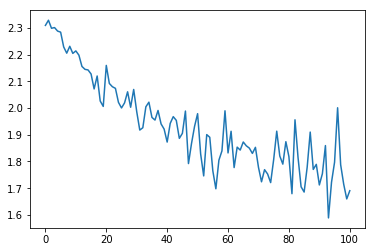

In [21]:
learn.recorder.plot_loss()

In [22]:
# lamb optimizer
learn2 = get_learner(nfs, data, 0.03, conv_layer, cb_funcs=cbfs, opt_func=lamb_opt())
%time learn2.fit(1) # lamb result

train: [1.879647571060183, tensor(0.3423)]
valid: [3.13885986328125, tensor(0.3400)]
CPU times: user 4min 34s, sys: 1min 24s, total: 5min 59s
Wall time: 3min 25s


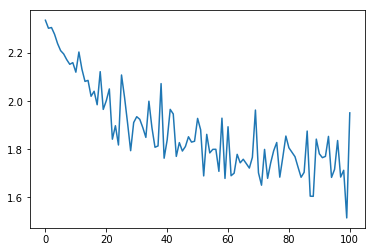

In [23]:
learn2.recorder.plot_loss()

In [28]:
# check if everything works
# cbfs += [CudaCallback]
learn3 = get_learner(nfs, data, 0.3, conv_layer, cb_funcs=cbfs, opt_func=lamb_opt())
phases = combine_scheds([0.3, 0.7], cos_1cycle_anneal(0.01, 0.06, 0.01))
sched = ParamScheduler('lr', phases)
learn3.fit(1, sched)

train: [1.949955678270901, tensor(0.3111)]
valid: [1.7068369140625, tensor(0.4040)]


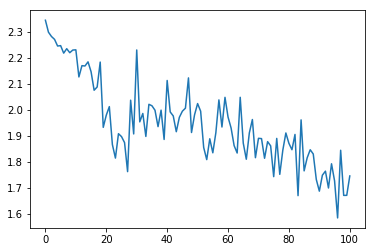

In [29]:
learn3.recorder.plot_loss()

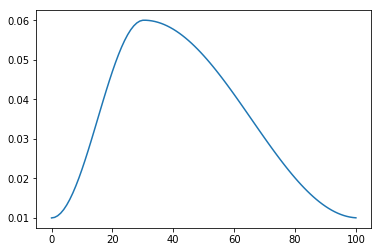

In [30]:
learn3.recorder.plot_lr()

# Progress bar

In [16]:
#export
# with progress bar version
import time

def format_time(t):
    t = int(t)
    h,m,s = t//3600, (t//60)%60, t%60
    if h!= 0: return f'{h}:{m:02d}:{s:02d}'
    else:     return f'{m:02d}:{s:02d}'
        
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
    
    def begin_fit(self):
        met_names = ['loss']+[m.__name__ for m in self.train_stats.metrics]
        names = ['epoch'] + [f'train_{n}' for n in met_names] + [
            f'valid_{n}' for n in met_names] + ['time']
        self.logger(names)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        self.start_time = time.time()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        #We use the logger function of the `Learner` here, it can be customized to write in a file or in a progress bar
        stats = [str(self.epoch)]
        for o in [self.train_stats, self.valid_stats]:
            stats += [f'{v:.6f}' for v in o.avg_stats]
        stats += [format_time(time.time() - self.start_time)]
        self.logger(stats) # the printing format can be easily revised
        
        

In [17]:
cbfs = [partial(AvgStatsCallback,accuracy),
        Recorder,
        partial(BatchTransformXCallback, norm_imagenette)]
learn3 = get_learner(nfs, data, 0.3, conv_layer, cb_funcs=cbfs, opt_func=lamb_opt())
phases = combine_scheds([0.3, 0.7], cos_1cycle_anneal(0.03, 0.1, 0.01))
sched = ParamScheduler('lr', phases)

In [18]:
learn3.fit(1, sched)

['epoch', 'train_loss', 'train_accuracy', 'valid_loss', 'valid_accuracy', 'time']
['0', '1.980094', '0.296262', '1.738751', '0.378000', '03:08']


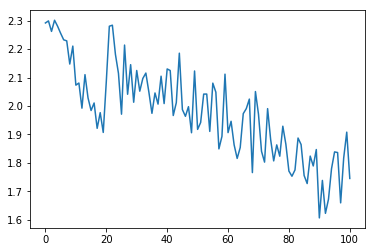

In [21]:
learn3.recorder.plot_loss()

## progressbar call back
- NOTE: require a fastai library fastprogress

In [20]:
#export
from fastprogress import master_bar, progress_bar
from fastprogress.fastprogress import format_time

class ProgressCallback(Callback):
    _order=-1
    def begin_fit(self):
        self.mbar = master_bar(range(self.epochs))
        self.mbar.on_iter_begin()
        self.run.logger = partial(self.mbar.write, table=True)
        
    def after_fit(self): self.mbar.on_iter_end()
    def after_batch(self): self.pb.update(self.iter)
    def begin_epoch   (self): self.set_pb()
    def begin_validate(self): self.set_pb()
        
    def set_pb(self):
        self.pb = progress_bar(self.dl, parent=self.mbar, auto_update=False)
        self.mbar.update(self.epoch)

In [22]:
cbfs = [partial(AvgStatsCallback,accuracy),
        Recorder,
        ProgressCallback,
        partial(BatchTransformXCallback, norm_imagenette)]
learn = get_learner(nfs, data, 0.3, conv_layer, cb_funcs=cbfs, opt_func=lamb_opt())
phases = combine_scheds([0.3, 0.7], cos_1cycle_anneal(0.03, 0.05, 0.02))
sched = ParamScheduler('lr', phases)

In [23]:
learn.fit(1,sched)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.906375,0.332015,1.753981,0.386000,02:55


# Export

In [ ]:
!./notebook2script.py Learner_Lesson5_3.ipynb